In [2]:
from PIL import Image, ImageChops, ImageFilter
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from cv2 import cv2
import os
from torch.utils.data import DataLoader
%matplotlib inline

# Visualize feature warp

In [3]:
from models.networks import define_fw255
from models.pwclite import resize_flow

In [4]:
class Args:
    dataset_mode = 'vishaoff'
    dataroot = '/nfs/bigcornea/add_disk0/shilinhu/ViSha/train/images'
    phase = 'train'
    max_dataset_size = float('inf')
    load_size = 512
    crop_size = 512
    batch_size = 8
    serial_batches = False
    num_threads = 8
    preprocess = 'resize'
    no_flip = False
    isTrain = True
    union = False
    gpu_ids = [0]
    upsample = True
    n_frames = 2
    reduce_dense = True
    num_classes = 1
    backbone = 'mobilenet'
    output_stride = 16
    sync_bn = None
    freeze_bn = False

opt = Args()

In [5]:
netFW = define_fw255(opt.num_classes, opt.backbone, opt.output_stride, opt.sync_bn, opt.freeze_bn, gpu_ids=opt.gpu_ids)

loading pretrained model of MobileNet...
initializing decoder params
loading pretrained model of MobileNet...
initializing decoder params


In [6]:
load_path = '/nfs/bigcornea/add_disk0/shilinhu/test_framework/checkpoints/off_half/iter_50000_net_FW.pth'
state_dict = torch.load(load_path)
netFW = netFW.module
netFW.load_state_dict(state_dict)
netFW.eval()

FWNet255(
  (backbone1): MobileNetV2(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
          (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [7]:
path_im1 = '/nfs/bigcornea/add_disk0/shilinhu/ViSha/test/images/roadblock/00000051.jpg'
path_im2 = '/nfs/bigcornea/add_disk0/shilinhu/ViSha/test/images/roadblock/00000052.jpg'

In [8]:
transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor()
])
img1 = Image.open(path_im1).convert('RGB')
img2 = Image.open(path_im2).convert('RGB')
img1 = transform(img1)
img2 = transform(img2)
img1 = img1.unsqueeze(0).cuda()
img2 = img2.unsqueeze(0).cuda()

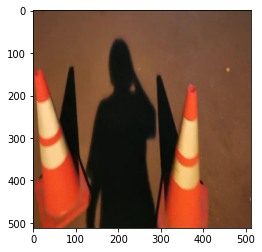

In [30]:
imshow(img2.detach().cpu().squeeze(0).numpy().transpose(1,2,0))

In [9]:
path_flow12 = '/nfs/bigcornea/add_disk0/shilinhu/ViSha/test/flow12/roadblock/00000052.npy'
path_flow21 = '/nfs/bigcornea/add_disk0/shilinhu/ViSha/test/flow21/roadblock/00000051.npy'

In [10]:
flow12 = np.load(path_flow12)
flow12 = flow12.transpose(2,0,1)
flow12 = torch.from_numpy(flow12)
flow12 = flow12.unsqueeze(0).cuda()
flow21 = np.load(path_flow21)
flow21 = flow21.transpose(2,0,1)
flow21 = torch.from_numpy(flow21)
flow21 = flow21.unsqueeze(0).cuda()

In [11]:
transflow12 = netFW.flowcnn(flow12, img1, img2, torch.abs(img1-img2))
transflow21 = netFW.flowcnn(flow21, img2, img1, torch.abs(img2-img1))

In [12]:
tf12d1 = resize_flow(flow12, (256,256))
tf12d2 = resize_flow(tf12d1, (128,128))
tf12d3 = resize_flow(tf12d2, (64,64))
tf12d4 = resize_flow(tf12d3, (32,32))
tf21d1 = resize_flow(flow21, (256,256))
tf21d2 = resize_flow(tf21d1, (128,128))
tf21d3 = resize_flow(tf21d2, (64,64))
tf21d4 = resize_flow(tf21d3, (32,32))

In [13]:
low_level_feat1 = netFW.backbone1.low_level_features(img1)
low_level_feat2 = netFW.backbone2.low_level_features(img2)
warped_low_1 = netFW.warp(low_level_feat1, tf21d2)        
warped_low_2 = netFW.warp(low_level_feat2, tf12d2)
new_low_feat1 = netFW.weight2_1_low * warped_low_2 + netFW.weight1_1_low * low_level_feat1
new_low_feat2 = netFW.weight1_2_low * warped_low_1 + netFW.weight2_2_low * low_level_feat2

middle_level_feat1 = netFW.backbone1.middle_level_features(new_low_feat1)
middle_level_feat2 = netFW.backbone2.middle_level_features(new_low_feat2)
warped_mid_1 = netFW.warp(middle_level_feat1, tf21d3)
warped_mid_2 = netFW.warp(middle_level_feat2, tf12d3)
new_mid_feat1 = netFW.weight2_1_mid * warped_mid_2 + netFW.weight1_1_mid * middle_level_feat1
new_mid_feat2 = netFW.weight1_2_mid * warped_mid_1 + netFW.weight2_2_mid * middle_level_feat2

high_level_feat1 = netFW.backbone1.high_level_features(new_mid_feat1)
high_level_feat2 = netFW.backbone2.high_level_features(new_mid_feat2)
warped_high_1 = netFW.warp(high_level_feat1, tf21d4)
warped_high_2 = netFW.warp(high_level_feat2, tf12d4)
new_high_feat1 = netFW.weight2_1_hig * warped_high_2 + netFW.weight1_1_hig * high_level_feat1       
new_high_feat2 = netFW.weight1_2_hig * warped_high_1 + netFW.weight2_2_hig * high_level_feat2

x1 = netFW.reduce1_1(new_high_feat1)
dsc1 = netFW.dsc1(x1)
x1 = netFW.reduce1_2(torch.cat((new_high_feat1, dsc1), 1))

x1 = netFW.decoder1(dsc1, new_low_feat1, new_mid_feat1, x1) # 256,256,256,256
x1 = F.interpolate(x1, size=img1.size()[2:], mode='bilinear', align_corners=True)       
x1 = torch.sigmoid(x1)

x2 = netFW.reduce2_1(new_high_feat2)
dsc2 = netFW.dsc2(x2)
x2 = netFW.reduce2_2(torch.cat((new_high_feat2, dsc2), 1))

x2 = netFW.decoder2(dsc2, new_low_feat2, new_mid_feat2, x2) # 256,256,256,256
x2 = F.interpolate(x2, size=img2.size()[2:], mode='bilinear', align_corners=True)    
x2 = torch.sigmoid(x2)

/home/shilinhu/miniconda3/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.au

In [14]:
p1 = x1.detach().cpu().squeeze(0).numpy()
p2 = x2.detach().cpu().squeeze(0).numpy()

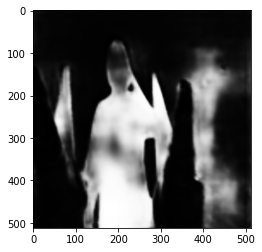

In [15]:
imshow(p1[0], 'gray')

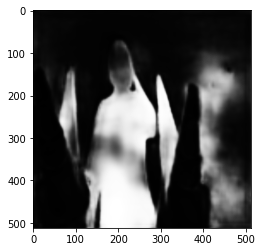

In [16]:
imshow(p2[0], 'gray')

In [31]:
feat1 = low_level_feat1.detach().cpu().squeeze(0).numpy()
warp_feat2 = warped_low_2.detach().cpu().squeeze(0).numpy()
comb_feat1 = new_low_feat1.detach().cpu().squeeze(0).numpy()

feat2 = low_level_feat2.detach().cpu().squeeze(0).numpy()
warp_feat1 = warped_low_1.detach().cpu().squeeze(0).numpy()
comb_feat2 = new_low_feat2.detach().cpu().squeeze(0).numpy()

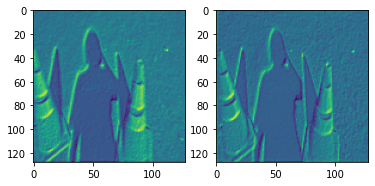

In [44]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(feat1[4])
axarr[1].imshow(feat2[4])

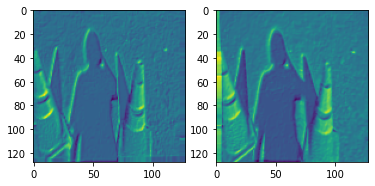

In [45]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(warp_feat2[4])
axarr[1].imshow(warp_feat1[4])

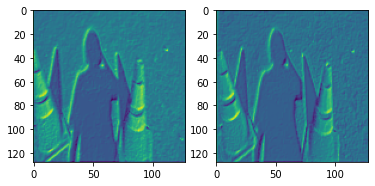

In [46]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(comb_feat1[4])
axarr[1].imshow(comb_feat2[4])

# Visualize flow

In [2]:
from models.pwclite import resize_flow, flow_warp
from util.util import compute_color

In [3]:
def warp(x, flo):
    """
    warp an image/tensor (im2) back to im1, according to the optical flow
    x: [B, C, H, W] (im2)
    flo: [B, 2, H, W] flow
    """
    B, C, H, W = x.size()
    # mesh grid 
    xx = torch.arange(0, W).view(1,-1).repeat(H,1)
    yy = torch.arange(0, H).view(-1,1).repeat(1,W)
    xx = xx.view(1,1,H,W).repeat(B,1,1,1)
    yy = yy.view(1,1,H,W).repeat(B,1,1,1)
    grid = torch.cat((xx,yy),1).float()

    vgrid = grid + flo

    # scale grid to [-1,1] 
    vgrid[:,0,:,:] = 2.0*vgrid[:,0,:,:].clone() / max(W-1,1)-1.0
    vgrid[:,1,:,:] = 2.0*vgrid[:,1,:,:].clone() / max(H-1,1)-1.0

    vgrid = vgrid.permute(0,2,3,1)        
    output = torch.nn.functional.grid_sample(x, vgrid, padding_mode='border', align_corners=True)
    mask = torch.ones(x.size())
    mask = torch.nn.functional.grid_sample(mask, vgrid, padding_mode='border', align_corners=True)

    mask[mask<0.9999] = 0
    mask[mask>0] = 1

    return output*mask

In [58]:
path_flow12 = '/nfs/bigcornea/add_disk0/shilinhu/SBUTimeLapse/flow12/beachcity.mp4/72.npy'
path_trfl12 = '/home/shilinhu/unet/results/flowcnn255/test_latest_iter50000/beachcity.mp4/72transflow12.npy'

In [68]:
path_flow12 = '/nfs/bigcornea/add_disk0/shilinhu/ViSha/test/flow12/dance2/00000044.npy'
path_trfl12 = '/home/shilinhu/unet/results/flowcnn_off_half/test_latest_iter50000/dance2/00000044transflow12.npy'

In [69]:
flow12 = np.load(path_flow12)
trfl12 = np.load(path_trfl12).transpose(2,0,1)
trfl12 = torch.from_numpy(trfl12).unsqueeze(0)
trfl12 = resize_flow(trfl12,(512,512))
trfl12 = trfl12[0].numpy().transpose(1,2,0)

In [71]:
print(np.min(flow12))
print(np.min(trfl12))

-7.885049
-3.8065047


In [66]:
baseflow = torch.from_numpy(flow12.transpose(2,0,1)).unsqueeze(0)
halfflow = resize_flow(baseflow,(256,256))
poolflow = nn.AvgPool2d(2, 2)(baseflow)

In [67]:
print(baseflow.max())
print(halfflow.shape)
print(poolflow.shape)
print(halfflow.max())
print(poolflow.max())

tensor(6.4686)
torch.Size([1, 2, 256, 256])
torch.Size([1, 2, 256, 256])
tensor(3.2228)
tensor(6.4537)


In [20]:
def flow_2_image(flow):
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    UNKNOW_FLOW_THRESHOLD = 1e7
    pr1 = abs(u) > UNKNOW_FLOW_THRESHOLD
    pr2 = abs(v) > UNKNOW_FLOW_THRESHOLD
    idx_unknown = (pr1 | pr2)
    u[idx_unknown] = v[idx_unknown] = 0

    # get max value in each direction
    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.
    maxu = max(maxu, np.max(u))
    maxv = max(maxv, np.max(v))
    minu = min(minu, np.min(u))
    minv = min(minv, np.min(v))

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(-1, np.max(rad))
    u = u / maxrad + np.finfo(float).eps
    v = v / maxrad + np.finfo(float).eps

    img = compute_color(u, v)

    idx = np.repeat(idx_unknown[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return np.uint8(img)

In [14]:
flim = flow_2_image(flow12)
trim = flow_2_image(trfl12)

In [90]:
def flow_to_image(flow, max_flow=256):
    if max_flow is not None:
        max_flow = max(max_flow, 1.)
    else:
        max_flow = np.max(abs(flow))
    n = 1
    u, v = flow[:, :, 0], flow[:, :, 1]
    mag = np.sqrt(np.square(u) + np.square(v))
    angle = np.arctan2(v, u)
    im_h = np.mod(angle / (2 * np.pi) + 1, 1)
    im_s = np.clip(mag * n / max_flow, a_min=0, a_max=1)
    im_v = np.clip(n - im_s, a_min=0, a_max=1)
    im = hsv_to_rgb(np.stack([im_h, im_s, im_v], 2))
    return (im * 255).astype(np.uint8)

In [181]:
flim = flow_to_image(flow12, 8)
trim = flow_to_image(trfl12, 1)

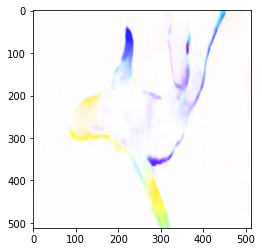

In [15]:
imshow(flim)

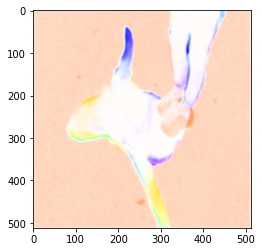

In [16]:
imshow(trim)

In [238]:
path_rc = '/nfs/bigcornea/add_disk0/shilinhu/SBUTimeLapse/frames/beachcity.mp4/71.png'
path_im = '/nfs/bigcornea/add_disk0/shilinhu/SBUTimeLapse/frames/beachcity.mp4/72.png'

In [17]:
path_rc = '/nfs/bigcornea/add_disk0/shilinhu/ViSha/test/images/dance2/00000043.jpg'
path_im = '/nfs/bigcornea/add_disk0/shilinhu/ViSha/test/images/dance2/00000044.jpg'

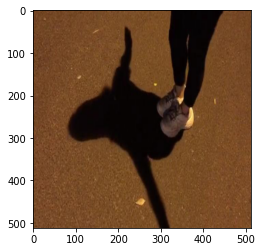

In [36]:
img = Image.open(path_im).convert('RGB')
img = transforms.Resize((512,512))(img)
imshow(img)

In [37]:
img = np.array(img).transpose(2,0,1)
img = torch.from_numpy(img).float().unsqueeze(0)

In [38]:
reconim = flow_warp(img, torch.from_numpy(trfl12.transpose(2,0,1)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


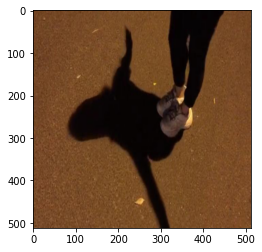

In [39]:
reconim = reconim.squeeze(0).numpy().transpose(1,2,0) / 255
imshow(reconim)

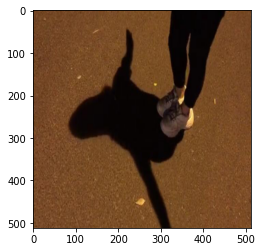

In [19]:
pimg = Image.open(path_rc).convert('RGB')
pimg = transforms.Resize((512,512))(pimg)
imshow(pimg)

# Test compute flow in process

In [5]:
from data import create_dataset

In [6]:
class Args:
    dataset_mode = 'vishaoff'
    dataroot = '/nfs/bigcornea/add_disk0/shilinhu/ViSha/train/images'
    phase = 'train'
    max_dataset_size = float('inf')
    load_size = 512
    crop_size = 512
    batch_size = 8
    serial_batches = False
    num_threads = 8
    preprocess = 'resize'
    no_flip = False
    isTrain = True
    union = False
    gpu_ids = 1,2
    upsample = True
    n_frames = 2
    reduce_dense = True

opt = Args()

In [7]:
dataset = create_dataset(opt)

dataset [ViShaOffDataset] was created


In [7]:
loader = iter(dataset)

In [28]:
data = next(loader)

In [35]:
path1 = '/nfs/bigcornea/add_disk0/shilinhu/ViSha/train/images/exercise/00000055.jpg'
path2 = '/nfs/bigcornea/add_disk0/shilinhu/ViSha/train/images/exercise/00000060.jpg'
transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor()
])
img1 = Image.open(path1).convert('RGB')
img2 = Image.open(path2).convert('RGB')
img1 = transform(img1)
img2 = transform(img2)
img1 = img1.unsqueeze(0)
img2 = img2.unsqueeze(0)

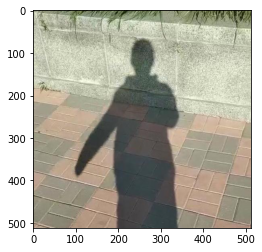

In [57]:
imshow(img1.squeeze(0).numpy().transpose(1,2,0))

In [37]:
test_shape = [448,1024]
flow_input1 = F.interpolate(img1, size=test_shape, mode='bilinear', align_corners=True)
flow_input2 = F.interpolate(img2, size=[448,1024], mode='bilinear', align_corners=True)

In [38]:
flow_input2.size()

torch.Size([1, 3, 448, 1024])

In [39]:
from models.pwclite import PWCLite
from models.pwclite import restore_model

In [40]:
net = PWCLite(opt)
net = restore_model(net, '/home/shilinhu/ARFlow/checkpoints/Sintel/pwclite_ar.tar')
net.eval()

PWCLite(
  (leakyRELU): LeakyReLU(negative_slope=0.1, inplace=True)
  (feature_pyramid_extractor): FeatureExtractor(
    (convs): ModuleList(
      (0): Sequential(
        (0): Sequential(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.1, inplace=True)
        )
        (1): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.1, inplace=True)
        )
      )
      (1): Sequential(
        (0): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.1, inplace=True)
        )
        (1): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.1, inplace=True)
        )
      )
      (2): Sequential(
        (0): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3),

In [41]:
flow_input = torch.cat([flow_input1, flow_input2], 1)
flow = net(flow_input)

In [42]:
def resize_flow(flow, new_shape):
    _, _, h, w = flow.shape
    new_h, new_w = new_shape
    flow = torch.nn.functional.interpolate(flow, (new_h, new_w),
                                           mode='bilinear', align_corners=True)
    scale_h, scale_w = h / float(new_h), w / float(new_w)
    flow[:, 0] /= scale_w
    flow[:, 1] /= scale_h
    return flow

In [43]:
flow12 = flow['flows_fw'][0]
flow21 = flow['flows_bw'][0]
flow12 = resize_flow(flow12, (512, 512))
flow21 = resize_flow(flow21, (512, 512))

In [44]:
from models.networks import FlowCNN

In [45]:
model = FlowCNN()
model.eval()

FlowCNN(
  (conv1): Conv2d(11, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(4, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [46]:
model_dict = model.state_dict()
pretrained_path = '/nfs/bigcornea/add_disk0/shilinhu/test_framework/checkpoints/flowcnn_off_half/iter_50000_net_FW.pth'
pretrained_dict = torch.load(pretrained_path)

new_dict = {}
for k, v in pretrained_dict.items():
    if 'flowcnn' in k:
        newk = k[8:]
        if newk in model_dict:
            new_dict[newk] = v

model_dict.update(new_dict)
model.load_state_dict(new_dict)

<All keys matched successfully>

In [47]:
trfl12 = model(flow12, img1, img2, torch.abs(img1-img2))

In [50]:
im = flow_2_image(trfl12.detach().squeeze(0).numpy().transpose(1,2,0))

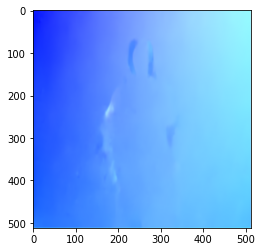

In [51]:
imshow(im)

In [54]:
reconim = warp(img2, trfl12.detach())

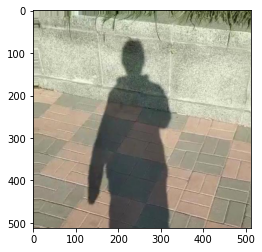

In [55]:
reconim = reconim.squeeze(0).numpy().transpose(1,2,0)
imshow(reconim)

# BER Acc

In [2]:
def cal_BER(prediction, label, thr = 127.5):
    prediction = (prediction > thr)
    label = (label > thr)
    prediction_tmp = prediction.astype(np.float)
    label_tmp = label.astype(np.float)
    TP = np.sum(prediction_tmp * label_tmp)
    TN = np.sum((1 - prediction_tmp) * (1 - label_tmp))
    Np = np.sum(label_tmp)
    Nn = np.sum((1-label_tmp))
    BER = 0.5 * (2 - TP / Np - TN / Nn) * 100
    shadow_BER = (1 - TP / Np) * 100
    non_shadow_BER = (1 - TN / Nn) * 100

    return BER, shadow_BER, non_shadow_BER, 

In [99]:
ipred = '/home/shilinhu/unet/results/FSDNetvisha/prediction_50000/images/Human9/00000060.jpg'
vpred = '/home/shilinhu/unet/results/flowcnn/test_latest_iter40000/Human9/00000060.png'
gt = '/nfs/bigcornea/add_disk0/shilinhu/ViSha/test/labels/Human9/00000060.png'
ipredimg = np.array(Image.open(ipred).convert('L'))
vpredimg = np.array(Image.open(vpred).convert('L'))
gtimg = np.array(Image.open(gt).convert('L'))

In [102]:
b, sb, nsb = cal_BER(vpredimg, gtimg, thr=127.5)

In [103]:
print(100-b)
print(100-sb)
print(100-nsb)

87.06982633452496
75.6751269035533
98.46452576549663


# Flow pool

In [11]:
m = nn.AvgPool2d(2, stride=2)
n = torch.randn(8, 2, 64, 64)
output = m(n)

In [12]:
output.size()

torch.Size([8, 2, 32, 32])

# Union ViSha and unlabel

In [2]:
def make_union_dataset(root, isTrain):
    groups = []
    imgs = []
    if isTrain:
        mpath = os.path.join('ViSha', 'train', 'images')
        for folder in os.listdir(os.path.join(root, mpath)):
            if os.path.isdir(os.path.join(root, mpath, folder)):
                images = [os.path.join(mpath, folder, img_name) for img_name in 
                          os.listdir(os.path.join(root, mpath, folder)) if img_name.endswith('.jpg')]
                images.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
                imgs.extend(images)
                groups.extend(images[0:(len(images)-1)])
        mpath = os.path.join('small_shadow', 'train')
        for folder in os.listdir(os.path.join(root, mpath)):
            if os.path.isdir(os.path.join(root, mpath, folder)):
                images = [os.path.join(mpath, folder, img_name) for img_name in 
                          os.listdir(os.path.join(root, mpath, folder)) if img_name.endswith('.jpg')]
                images.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
                imgs.extend(images)
                groups.extend(images[0:(len(images)-1)])
    return imgs, groups

In [3]:
imgs, groups = make_union_dataset('/nfs/bigcornea/add_disk0/shilinhu/', True)

In [23]:
image_path = groups[5000]
idx = imgs.index(image_path)

In [24]:
image_path

'small_shadow/train/sv252/frame113.jpg'

In [32]:
root = '/nfs/bigcornea/add_disk0/shilinhu/'

In [37]:
subname = image_path.split('/')[1]
fir_img = Image.open(os.path.join(root, imgs[idx])).convert('RGB')
sec_img = Image.open(os.path.join(root, imgs[idx+1])).convert('RGB')
flow12 = np.load(os.path.join(root, 'flow_512', 
                              imgs[idx].split('/')[-2],
                              'flow_'+imgs[idx].split('/')[-1][:-4]+'.npy'))
flow21 = np.load(os.path.join(root, 'flow_512_bw', 
                              imgs[idx].split('/')[-2],
                              'flow_'+imgs[idx].split('/')[-1][:-4]+'.npy'))
flow12 = flow12.transpose(2,0,1)
flow12 = torch.from_numpy(flow12)

In [38]:
flow12.size()

torch.Size([2, 512, 512])

In [39]:
def relabel_dataset(groups):
    unlabeled_idxs = []
    for idx in range(len(groups)):
        if 'small_shadow' in groups[idx]:
            unlabeled_idxs.append(idx)
    labeled_idxs = sorted(set(range(len(groups))) - set(unlabeled_idxs))

    return labeled_idxs, unlabeled_idxs

In [40]:
l_id, u_id = relabel_dataset(groups)

In [19]:
np.exp(-5.0 ** 0.001)

0.36728736230732817

In [5]:
from data import create_dataset

In [2]:
class Args:
    dataset_mode = 'union'
    dataroot = '/nfs/bigcornea/add_disk0/shilinhu'
    phase = 'train'
    max_dataset_size = float('inf')
    load_size = 512
    crop_size = 512
    batch_size = 16
    labeled_bs = 8
    serial_batches = True
    num_threads = 8
    preprocess = 'resize'
    no_flip = True
    isTrain = True
    union = True
    gpu_ids = 1,2

opt = Args()

In [5]:
opt.gpu_ids[0]

1

In [7]:
dataset = create_dataset(opt)

dataset [UnionDataset] was created


In [5]:
len(dataset)

592

In [12]:
batch = next(iter(dataset.batch_sampler))

In [50]:
data0 = next(iter(dataset))

In [51]:
data0['A1'][10].size()

torch.Size([3, 512, 512])

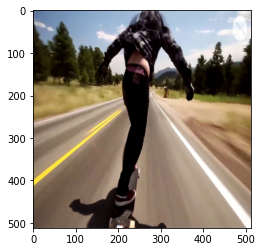

In [52]:
imshow(np.transpose(data0['A2'][10].numpy(), (1,2,0)))

# Test ViSha

In [1]:
a = [('Plane_ce2/00000001.jpg',), ('Plane_ce2/00000002.jpg',)]

In [3]:
a[0][0]

'Plane_ce2/00000001.jpg'

In [4]:
short_path1 = a[0][0].split('/')[-1]

In [5]:
short_path1

'00000001.jpg'

In [28]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def get_imlist(dir):
    images = []

    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname):
                path = os.path.join(root, fname)
                subname = path.split('/')
                images.append(os.path.join(subname[-2],subname[-1]))
    return images

In [29]:
images = get_imlist('/nfs/bigcornea/add_disk0/shilinhu/ViSha/test/labels')

In [30]:
images

['Ball_ce2/00000038.png',
 'Ball_ce2/00000062.png',
 'Ball_ce2/00000052.png',
 'Ball_ce2/00000091.png',
 'Ball_ce2/00000079.png',
 'Ball_ce2/00000086.png',
 'Ball_ce2/00000045.png',
 'Ball_ce2/00000034.png',
 'Ball_ce2/00000011.png',
 'Ball_ce2/00000053.png',
 'Ball_ce2/00000004.png',
 'Ball_ce2/00000026.png',
 'Ball_ce2/00000066.png',
 'Ball_ce2/00000097.png',
 'Ball_ce2/00000035.png',
 'Ball_ce2/00000027.png',
 'Ball_ce2/00000071.png',
 'Ball_ce2/00000046.png',
 'Ball_ce2/00000019.png',
 'Ball_ce2/00000098.png',
 'Ball_ce2/00000017.png',
 'Ball_ce2/00000057.png',
 'Ball_ce2/00000061.png',
 'Ball_ce2/00000041.png',
 'Ball_ce2/00000092.png',
 'Ball_ce2/00000030.png',
 'Ball_ce2/00000018.png',
 'Ball_ce2/00000051.png',
 'Ball_ce2/00000082.png',
 'Ball_ce2/00000081.png',
 'Ball_ce2/00000084.png',
 'Ball_ce2/00000094.png',
 'Ball_ce2/00000069.png',
 'Ball_ce2/00000010.png',
 'Ball_ce2/00000065.png',
 'Ball_ce2/00000009.png',
 'Ball_ce2/00000003.png',
 'Ball_ce2/00000059.png',
 'Ball_ce2/0

# Multi-class for energy

In [7]:
a = torch.randn(3, 16, 16).cuda(6)

In [8]:
a.size()

torch.Size([3, 16, 16])

In [10]:
isinstance(a, torch.Tensor)

True

In [9]:
a.type()

'torch.cuda.FloatTensor'

In [6]:
b = torch.argmax(a, dim=0, keepdim=True)

In [7]:
b.size()

torch.Size([1, 16, 16])

In [9]:
b

tensor([[[2, 0, 2, 2, 1, 1, 2, 1, 1, 1, 0, 1, 1, 0, 2, 0],
         [0, 2, 1, 0, 1, 0, 1, 0, 2, 0, 2, 0, 0, 0, 1, 2],
         [1, 2, 0, 2, 2, 0, 0, 1, 0, 1, 0, 2, 2, 1, 0, 0],
         [1, 0, 1, 2, 2, 1, 1, 2, 0, 2, 1, 2, 1, 2, 2, 1],
         [1, 2, 2, 2, 1, 0, 0, 1, 0, 1, 1, 1, 0, 2, 2, 0],
         [1, 2, 1, 0, 2, 2, 1, 2, 2, 2, 1, 2, 0, 2, 0, 1],
         [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 2],
         [1, 2, 0, 1, 2, 1, 1, 0, 2, 1, 2, 1, 0, 2, 1, 2],
         [0, 2, 1, 2, 0, 2, 2, 1, 0, 0, 0, 2, 2, 2, 2, 0],
         [1, 2, 1, 0, 2, 1, 2, 2, 1, 0, 0, 0, 1, 1, 1, 0],
         [0, 1, 1, 0, 0, 0, 2, 1, 2, 2, 1, 0, 1, 1, 1, 1],
         [0, 1, 0, 1, 0, 2, 2, 2, 0, 1, 0, 1, 0, 2, 0, 0],
         [2, 0, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 0, 2],
         [0, 1, 0, 1, 0, 1, 2, 2, 1, 1, 1, 0, 2, 0, 2, 1],
         [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 2, 2, 0, 0, 1, 0],
         [0, 1, 0, 1, 1, 2, 0, 1, 0, 0, 1, 0, 0, 0, 2, 2]]])

In [8]:
b.type()

'torch.LongTensor'

In [13]:
b.float()/2

tensor([[[1.0000, 0.0000, 1.0000, 1.0000, 0.5000, 0.5000, 1.0000, 0.5000,
          0.5000, 0.5000, 0.0000, 0.5000, 0.5000, 0.0000, 1.0000, 0.0000],
         [0.0000, 1.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.5000, 0.0000,
          1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.5000, 1.0000],
         [0.5000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.5000,
          0.0000, 0.5000, 0.0000, 1.0000, 1.0000, 0.5000, 0.0000, 0.0000],
         [0.5000, 0.0000, 0.5000, 1.0000, 1.0000, 0.5000, 0.5000, 1.0000,
          0.0000, 1.0000, 0.5000, 1.0000, 0.5000, 1.0000, 1.0000, 0.5000],
         [0.5000, 1.0000, 1.0000, 1.0000, 0.5000, 0.0000, 0.0000, 0.5000,
          0.0000, 0.5000, 0.5000, 0.5000, 0.0000, 1.0000, 1.0000, 0.0000],
         [0.5000, 1.0000, 0.5000, 0.0000, 1.0000, 1.0000, 0.5000, 1.0000,
          1.0000, 1.0000, 0.5000, 1.0000, 0.0000, 1.0000, 0.0000, 0.5000],
         [0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.5000, 0.0000

In [48]:
c = torch.arange(16,0,-1).float()

In [49]:
c.type()

'torch.FloatTensor'

In [23]:
path = '/nfs/bigcornea/add_disk0/shilinhu/test_framework/checkpoints/esd/web/images/iter12000_output1_img.png'

In [24]:
img = Image.open(path).convert('L')

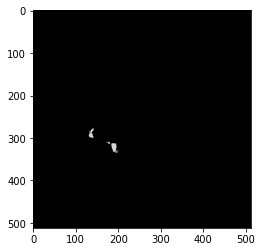

In [25]:
imshow(img,'gray')

In [26]:
np.array(img)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

# Diff of frames

In [23]:
path1 = '/nfs/bigcornea/add_disk0/shilinhu/small_shadow/train/sv001/frame0.jpg'
path2 = '/nfs/bigcornea/add_disk0/shilinhu/small_shadow/train/sv001/frame10.jpg'

In [24]:
img1 = Image.open(path1).convert('RGB')
img2 = Image.open(path2).convert('RGB')

In [27]:
img1 = np.asarray(img1)
img2 = np.asarray(img2)

In [36]:
diff = np.abs(img1-img2)

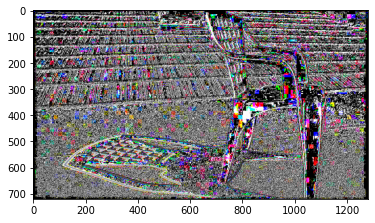

In [37]:
imshow(diff)

# Change mobilenet

In [18]:
from models.backbone import mobilenet
from models.networks import FSDNet, ESDNet

In [25]:
net = ESDNet()

loading pretrained model of MobileNet...
initializing decoder params
loading pretrained model of MobileNet...
initializing decoder params
loading pretrained model of MobileNet...
initializing decoder params


In [26]:
net.branch3.backbone.low_level_features[0]

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU6(inplace=True)
)

In [27]:
net.branch3.backbone.low_level_features[0] = mobilenet.conv_bn(5, 32, 2, nn.BatchNorm2d)

In [28]:
net.branch3.backbone.low_level_features[0]

Sequential(
  (0): Conv2d(5, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU6(inplace=True)
)

# Flowwarp net

In [2]:
import models.networks

In [3]:
netFW = models.networks.define_fw(1, 'mobilenet', 16, None, False, gpu_ids=[7])

loading pretrained model of MobileNet...
initializing decoder params
loading pretrained model of MobileNet...
initializing decoder params


In [4]:
for m in netFW.module.flowdown2.named_modules():
    if isinstance(m[1], nn.Conv2d) \
                        or isinstance(m[1], nn.BatchNorm2d):
        for p in m[1].parameters():
            if p.requires_grad:
                print(p.is_leaf)

True


In [7]:
for m in netFW.module.weight1_1:
    if m.requires_grad:
        print(p.is_leaf)

True
True
True


In [5]:
netFW.module.flowcnn

FlowCNN(
  (conv1): Conv2d(11, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(4, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [13]:
netFW.module.flowdown1.parameters

<bound method Module.parameters of Sequential(
  (0): Conv2d(2, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): ReLU6(inplace=True)
)>

In [12]:
train_params = [{'params': netFW.module.get_1x_lr_params(), 'lr': 5e-3}, 
                {'params': netFW.module.get_10x_lr_params(), 'lr': 5e-2}]

In [13]:
optimizer = torch.optim.SGD(train_params, lr=5e-3, momentum=0.9, weight_decay=5e-4)

In [40]:
class FlowCNN(nn.Module):
    def __init__(self):
        super(FlowCNN, self).__init__()
        self.conv1 = nn.Conv2d(11, 16, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 2, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(4, 2, 3, stride=1, padding=1)
        self.w = nn.Parameter(torch.ones(3))
        
    def forward(self, flow, f1, f2, diff):
        x = torch.cat([flow, f1, f2, diff], dim=1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.cat([x, flow], dim=1)
        x = self.conv4(x)
        return x
    
    def get_10x_lr_params(self):
        modules = [self.conv1, self.conv2, self.conv3, self.conv4]
        for i in range(len(modules)):
            for m in modules[i].named_modules():
                if isinstance(m[1], nn.Conv2d) or isinstance(m[1], SynchronizedBatchNorm2d) \
                        or isinstance(m[1], nn.BatchNorm2d):
                    for p in m[1].parameters():
                        if p.requires_grad:
                            print(p)

In [41]:
net = FlowCNN()

In [44]:
weights = [net.w]
for m in weights[0]:
    if m.requires_grad:
        print(m)

tensor(1., grad_fn=<SelectBackward>)
tensor(1., grad_fn=<SelectBackward>)
tensor(1., grad_fn=<SelectBackward>)


In [43]:
net.get_10x_lr_params()

Parameter containing:
tensor([[[[-0.0766, -0.0075,  0.0209],
          [ 0.0594, -0.0116, -0.0123],
          [-0.0495,  0.0339, -0.0260]],

         [[-0.0485, -0.0493, -0.0787],
          [-0.0774, -0.0250,  0.0646],
          [ 0.0694, -0.0177,  0.0842]],

         [[ 0.0099,  0.0720, -0.0927],
          [-0.0365,  0.0006, -0.0290],
          [ 0.0018,  0.0338,  0.0247]],

         ...,

         [[ 0.0669, -0.0437,  0.0570],
          [-0.0661, -0.0530, -0.0354],
          [-0.0809,  0.0830,  0.0443]],

         [[-0.0632,  0.0729, -0.0123],
          [-0.0004, -0.0205,  0.0361],
          [-0.0473, -0.0102, -0.0867]],

         [[-0.0997, -0.0004, -0.0708],
          [ 0.0628, -0.0566, -0.0802],
          [-0.0358,  0.0750, -0.0416]]],


        [[[ 0.0460, -0.0467,  0.0167],
          [ 0.0708, -0.0614, -0.0665],
          [-0.0845, -0.0518,  0.0124]],

         [[ 0.0509, -0.0824, -0.0403],
          [ 0.0909, -0.0629, -0.0121],
          [-0.0918,  0.0356, -0.0439]],

         

In [33]:
net.w[0]

tensor(1., grad_fn=<SelectBackward>)

In [16]:
img = torch.ones((1,2,512,512))

In [19]:
conv = nn.Conv2d(2,16,3,2,1)
feat = conv(img)

In [20]:
feat.size()

torch.Size([1, 16, 256, 256])

In [28]:
tensor1 = torch.rand(4,24,16,16)
tensor2 = torch.ones(1,24,1,1) * 2

In [29]:
print(tensor1.size())
print(tensor2.size())

torch.Size([4, 24, 16, 16])
torch.Size([1, 24, 1, 1])


In [24]:
tensor2 = tensor2.unsqueeze(dim=0)
tensor2 = tensor2.unsqueeze(dim=2)
tensor2 = tensor2.unsqueeze(dim=3)

In [30]:
print(tensor2)

tensor([[[[2.]],

         [[2.]],

         [[2.]],

         [[2.]],

         [[2.]],

         [[2.]],

         [[2.]],

         [[2.]],

         [[2.]],

         [[2.]],

         [[2.]],

         [[2.]],

         [[2.]],

         [[2.]],

         [[2.]],

         [[2.]],

         [[2.]],

         [[2.]],

         [[2.]],

         [[2.]],

         [[2.]],

         [[2.]],

         [[2.]],

         [[2.]]]])


In [31]:
t3 = tensor1 * tensor2
print(t3.size())

torch.Size([4, 24, 16, 16])


# Constraints on edges

In [5]:
path = '/nfs/bigcornea/add_disk0/shilinhu/SBU/SBUTrain4KRecoveredSmall/EdgeMasks/lssd12_edge.png'

In [6]:
img = Image.open(path).convert('L')

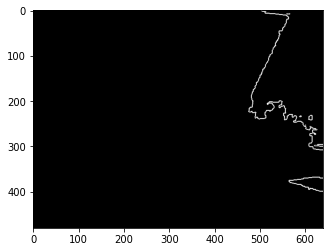

In [7]:
imshow(img, 'gray')

In [8]:
img = np.asarray(img)
np.unique(img)

array([  0, 255], dtype=uint8)

In [25]:
img_p = ImageChops.subtract(img.filter(ImageFilter.MaxFilter(5)), img.filter(ImageFilter.MinFilter(5)))

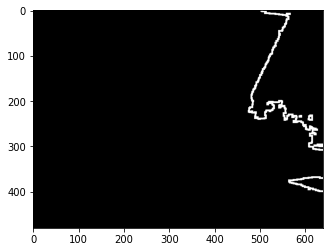

In [26]:
imshow(img_p, 'gray')

# Denormalize image

In [12]:
path = '/nfs/bigcornea/add_disk0/shilinhu/SBU/SBUTrain4KRecoveredSmall/ShadowImages/lssd12.jpg'

In [13]:
img = Image.open(path).convert('RGB')

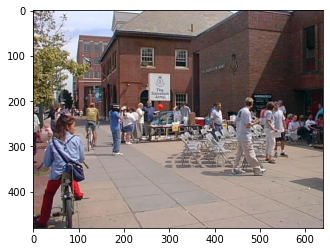

In [27]:
imshow(img)

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [17]:
img_t = transform(img)

In [20]:
def denormalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [21]:
img_d = denormalize(img_t)

In [22]:
img_d = np.transpose(img_d.float().numpy(), (1, 2, 0)) * 255.0

In [25]:
img_d = img_d.astype(np.uint8)

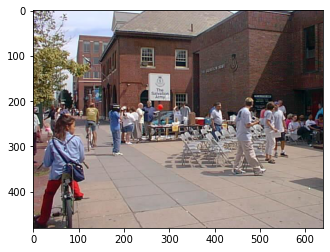

In [26]:
imshow(img_d)

# framework image make and save

In [2]:
img_path = '/nfs/bigcornea/add_disk0/shilinhu/ades2m/train/0001.jpg'

In [3]:
AB = Image.open(img_path).convert('RGB')

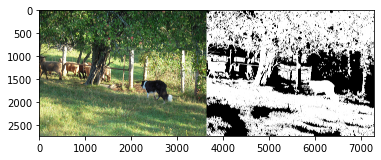

In [4]:
imshow(AB)

In [5]:
w, h = AB.size
w2 = int(w / 2)
A = AB.crop((0, 0, w2, h))
B = AB.crop((w2, 0, w, h))

In [7]:
def get_params(preprocess, load_size, crop_size, size):
    w, h = size
    new_h = h
    new_w = w
    if preprocess == 'resize_and_crop':
        new_h = new_w = load_size
    elif preprocess == 'scale_width_and_crop':
        new_w = load_size
        new_h = load_size * h // w

    x = random.randint(0, np.maximum(0, new_w - crop_size))
    y = random.randint(0, np.maximum(0, new_h - crop_size))

    flip = random.random() > 0.5

    return {'crop_pos': (x, y), 'flip': flip}

In [8]:
transform_params = get_params(preprocess='resize', load_size=512, crop_size=512, size=A.size)
transform_params

{'crop_pos': (2384, 1154), 'flip': False}

In [9]:
def get_transform(load_size, crop_size, preprocess='resize', params=None, grayscale=False, method=Image.BICUBIC, convert=True):
    transform_list = []
    if grayscale:
        transform_list.append(transforms.Grayscale(1))
    if 'resize' in preprocess:
        osize = [load_size, load_size]
        transform_list.append(transforms.Resize(osize, method))
    if convert:
        transform_list += [transforms.ToTensor()]
        if not grayscale:
            #transform_list += [transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
            transform_list += [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    return transforms.Compose(transform_list)

In [10]:
A_transform = get_transform(512, 512, 'resize', transform_params, grayscale=False)

In [11]:
B_transform = get_transform(512, 512, 'resize', transform_params, grayscale=True)

In [12]:
A = A_transform(A)
B = B_transform(B)

In [13]:
def tensor2im(input_image, imtype=np.uint8):
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):  # get the data from a variable
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor.cpu().float().numpy()  # convert it into a numpy array
        if image_numpy.shape[0] == 1:  # grayscale to RGB
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0  # post-processing: tranpose and scaling
    else:  # if it is a numpy array, do nothing
        image_numpy = input_image
    return image_numpy.astype(imtype)

In [14]:
image_B = tensor2im(B)

In [15]:
image_B = B.data.cpu()
image_B = transforms.ToPILImage()(image_B)

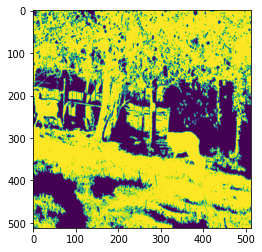

In [16]:
imshow(image_B)

# framework train input comparison

In [2]:
from data import create_dataset

In [3]:
class Args:
    dataset_mode = 'cuhk'
    dataroot = '/nfs/bigcornea/add_disk0/shilinhu/CUHKshadow'
    phase = 'train'
    max_dataset_size = float('inf')
    load_size = 512
    crop_size = 512
    input_nc = 3
    output_nc = 1
    batch_size = 6
    serial_batches = True
    num_threads = 8
    preprocess = 'resize'
    no_flip = True
    isTrain = True

opt = Args()

In [4]:
dataset = create_dataset(opt)

dataset [CUHKDataset] was created


In [5]:
dataset_size = len(dataset)    # get the number of images in the dataset.
print('The number of training images = %d' % dataset_size)

The number of training images = 7356


In [6]:
data1 = next(iter(dataset.dataloader))

In [7]:
data1

{'A': tensor([[[[0.2196, 0.2196, 0.2196,  ..., 0.0745, 0.0706, 0.0706],
           [0.2196, 0.2196, 0.2235,  ..., 0.0745, 0.0706, 0.0706],
           [0.2235, 0.2235, 0.2275,  ..., 0.0745, 0.0706, 0.0706],
           ...,
           [0.2549, 0.2549, 0.2549,  ..., 0.8039, 0.7882, 0.7804],
           [0.2588, 0.2588, 0.2588,  ..., 0.8039, 0.7882, 0.7804],
           [0.2588, 0.2588, 0.2627,  ..., 0.8039, 0.7882, 0.7804]],
 
          [[0.5294, 0.5294, 0.5333,  ..., 0.4353, 0.4314, 0.4314],
           [0.5294, 0.5294, 0.5333,  ..., 0.4353, 0.4314, 0.4314],
           [0.5333, 0.5333, 0.5373,  ..., 0.4353, 0.4314, 0.4314],
           ...,
           [0.2314, 0.2314, 0.2353,  ..., 0.7373, 0.7216, 0.7137],
           [0.2353, 0.2353, 0.2392,  ..., 0.7373, 0.7216, 0.7137],
           [0.2353, 0.2353, 0.2392,  ..., 0.7373, 0.7216, 0.7137]],
 
          [[0.8000, 0.8000, 0.8039,  ..., 0.7216, 0.7176, 0.7176],
           [0.8000, 0.8000, 0.8039,  ..., 0.7216, 0.7176, 0.7176],
           [0.8039,

In [8]:
data1['A'].size()

torch.Size([6, 3, 512, 512])

In [9]:
from dataset import ImageFolder
import joint_transforms
transform = transforms.Compose([
    transforms.ToTensor()
])
joint_transform = joint_transforms.Compose([
    joint_transforms.Resize((512, 512)),
])

In [10]:
path = '/nfs/bigcornea/add_disk0/shilinhu/CUHKshadow'
train_set = ImageFolder(path, transform=transform, target_transform=transform, joint_transform=joint_transform, is_train=True, batch_size=6)
train_loader = DataLoader(train_set, batch_size=6, num_workers=8, shuffle=False)

In [11]:
data2 = next(iter(train_loader))

In [12]:
data2

[tensor([[[[0.2196, 0.2196, 0.2196,  ..., 0.0745, 0.0706, 0.0706],
           [0.2196, 0.2196, 0.2235,  ..., 0.0745, 0.0706, 0.0706],
           [0.2235, 0.2235, 0.2275,  ..., 0.0745, 0.0706, 0.0706],
           ...,
           [0.2549, 0.2549, 0.2549,  ..., 0.8039, 0.7882, 0.7804],
           [0.2588, 0.2588, 0.2588,  ..., 0.8039, 0.7882, 0.7804],
           [0.2588, 0.2588, 0.2627,  ..., 0.8039, 0.7882, 0.7804]],
 
          [[0.5294, 0.5294, 0.5333,  ..., 0.4353, 0.4314, 0.4314],
           [0.5294, 0.5294, 0.5333,  ..., 0.4353, 0.4314, 0.4314],
           [0.5333, 0.5333, 0.5373,  ..., 0.4353, 0.4314, 0.4314],
           ...,
           [0.2314, 0.2314, 0.2353,  ..., 0.7373, 0.7216, 0.7137],
           [0.2353, 0.2353, 0.2392,  ..., 0.7373, 0.7216, 0.7137],
           [0.2353, 0.2353, 0.2392,  ..., 0.7373, 0.7216, 0.7137]],
 
          [[0.8000, 0.8000, 0.8039,  ..., 0.7216, 0.7176, 0.7176],
           [0.8000, 0.8000, 0.8039,  ..., 0.7216, 0.7176, 0.7176],
           [0.8039, 0.80

In [19]:
data2[0].size()

torch.Size([6, 3, 512, 512])

In [36]:
img1 = data1['B'][0].numpy().transpose(1,2,0)

In [37]:
img2 = data2[1][0].numpy().transpose(1,2,0)

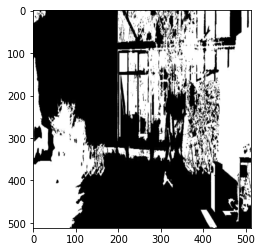

In [39]:
plt.imshow(img1, 'gray')

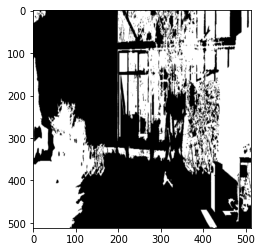

In [40]:
plt.imshow(img2, 'gray')

# framework test input comparison

In [2]:
path1 = '/nfs/bigcornea/add_disk0/shilinhu/CUHKshadow/fullset/test/2099.jpg'
path2 = '/home/shilinhu/unet/results/adefsd/test_latest_iter50000/output/2099_output.png'

In [3]:
img1 = Image.open(path1).convert('RGB')
img2 = Image.open(path2).convert('L')

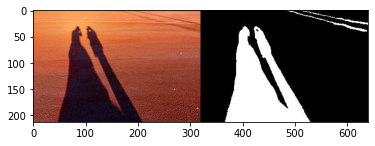

In [4]:
imshow(img1)

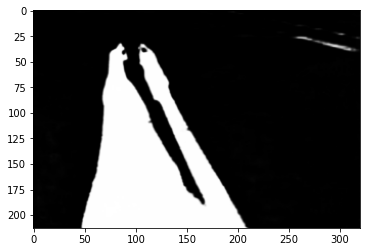

In [6]:
imshow(img2,'gray')

# framework loss comparison

In [4]:
log_ori_path = '/home/shilinhu/Shadow/FSDNet/ckpt/FSDNet/originalfsd.txt'
log_fra_path = '/nfs/bigcornea/add_disk0/shilinhu/test_framework/checkpoints/fsdfull/loss_log.txt'

In [5]:
with open(log_ori_path) as f:
    log_ori = f.readlines()
with open(log_fra_path) as f:
    log_fra = f.readlines()

In [16]:
log_fra = log_fra[2:]

In [18]:
len(log_fra)

54308

In [21]:
log_ori = log_ori[2:]

In [22]:
len(log_ori)

50001

In [34]:
log_fra = log_fra[4308:]

In [35]:
len(log_fra)

50000

In [37]:
log_ori = log_ori[:-1]

In [38]:
len(log_ori)

50000

In [40]:
ori = []
for line in log_ori:
    line = line.split('loss_net ')[1].split(']')[0]
    loss = float(line)
    ori.append(loss)

In [46]:
fra = []
for line in log_fra:
    line = line.split('fsd: ')[1].split(' ')[0]
    loss = float(line)
    fra.append(loss)

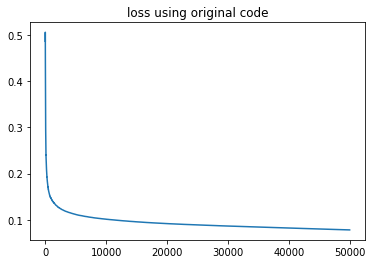

In [48]:
plt.plot(ori)
plt.title('loss using original code')
plt.show()

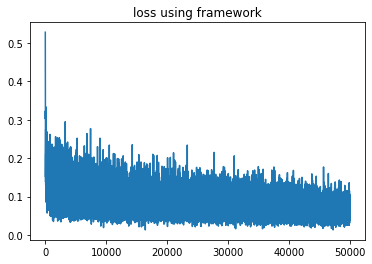

In [49]:
plt.plot(fra)
plt.title('loss using framework')
plt.show()

# framework output check

In [4]:
path1 = '/nfs/bigcornea/add_disk0/shilinhu/CUHKshadow/fullset/test/0000.jpg'

In [11]:
img1 = np.asarray(Image.open(path1).convert('L'))
h, w = img1.shape
img1 = img1[:, int(w/2):w]

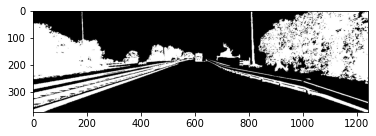

In [13]:
imshow(img1, 'gray')

In [16]:
path2 = '/nfs/bigcornea/add_disk0/shilinhu/CUHKshadow/test/mask_KITTI/000001.png'

In [17]:
img2 = np.asarray(Image.open(path2).convert('L'))

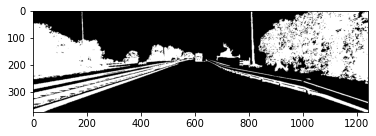

In [18]:
imshow(img2, 'gray')

In [20]:
img1

array([[  1,   0,   1, ..., 255, 255, 255],
       [  1,   0,   3, ..., 255, 255, 255],
       [  1,   0,   4, ..., 255, 255, 255],
       ...,
       [254, 254, 255, ..., 255, 255, 255],
       [254, 254, 255, ..., 255, 255, 255],
       [254, 253, 255, ..., 255, 255, 255]], dtype=uint8)

In [21]:
img2

array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

# framework model init

In [43]:
from models import create_model

In [63]:
class Args:
    model = 'fsd'
    gpu_ids = [0]
    isTrain = True
    checkpoints_dir = '/nfs/bigcorcea/add_disk0/shilinhu/test_framework/checkpoints/adefsd'
    name = 'adefsd'
    preprocess = 'resize'
    num_classes = 1
    backbone = 'mobilenet'
    output_stride = 16
    sync_bn = None
    freeze_bn = False
    lr = 0.005
    momentum = 0.9
    weight_decay = 5e-4

opt = Args()

In [64]:
model = create_model(opt)

loading pretrained model of MobileNet...
initializing decoder params
model [FSDModel] was created


In [68]:
print(model.netFSD)

DataParallel(
  (module): FSDNet(
    (backbone): MobileNetV2(
      (features): Sequential(
        (0): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
            (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
          (conv): Sequential(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2

In [82]:
for name, params in model.netFSD.named_parameters():
    print(name, params)

module.backbone.features.0.0.weight Parameter containing:
tensor([[[[ 4.4437e-02, -3.3907e-02, -1.3749e-01],
          [-9.7260e-02,  2.2346e-01,  8.5116e-01],
          [ 4.8016e-02, -1.8947e-01, -6.8666e-01]],

         [[ 7.6186e-02, -7.3707e-02, -1.2433e-01],
          [-2.0040e-01,  3.8383e-01,  1.3976e+00],
          [ 1.3307e-01, -3.6720e-01, -1.1924e+00]],

         [[-1.2272e-03,  1.9510e-03, -7.7929e-02],
          [-3.2213e-03,  7.3368e-02,  4.4664e-01],
          [-1.6807e-02, -5.6205e-02, -3.9442e-01]]],


        [[[-6.1015e-03,  5.4802e-03, -1.0519e-02],
          [ 8.0817e-03, -1.3923e-02, -2.6622e-02],
          [-3.8021e-03, -1.8611e-03, -4.7822e-03]],

         [[-2.6929e-04,  8.2633e-03, -2.4426e-03],
          [ 7.9231e-03, -3.0870e-02, -5.0077e-02],
          [ 8.6566e-05, -1.5057e-03, -5.8571e-03]],

         [[-6.3575e-03,  6.5947e-03,  2.3811e-03],
          [ 5.2314e-03, -2.0446e-02, -2.9179e-02],
          [ 4.0038e-03,  3.0850e-04,  7.4016e-03]]],


        

module.backbone.features.2.conv.0.weight Parameter containing:
tensor([[[[-0.0149]],

         [[-0.3701]],

         [[-0.0241]],

         ...,

         [[-0.0329]],

         [[-0.1274]],

         [[-0.0378]]],


        [[[-0.0655]],

         [[-0.0330]],

         [[ 0.3560]],

         ...,

         [[-0.1045]],

         [[-0.1665]],

         [[-0.1932]]],


        [[[-0.1850]],

         [[ 0.1736]],

         [[ 0.1731]],

         ...,

         [[-0.3107]],

         [[ 0.0169]],

         [[-0.3182]]],


        ...,


        [[[-0.0225]],

         [[ 0.0475]],

         [[ 0.1470]],

         ...,

         [[ 0.1652]],

         [[ 0.1706]],

         [[-0.3759]]],


        [[[-0.0779]],

         [[ 0.0475]],

         [[-0.0100]],

         ...,

         [[ 0.0345]],

         [[-0.0204]],

         [[-0.0870]]],


        [[[-0.0809]],

         [[ 0.0473]],

         [[ 0.1969]],

         ...,

         [[-0.1350]],

         [[ 0.0191]],

         [[-0.079

module.backbone.features.3.conv.1.bias Parameter containing:
tensor([ 0.2966,  0.1493,  0.1712,  0.1743,  0.0521,  0.1855,  0.2934,  0.3197,
        -0.1569,  0.1588,  0.2454,  0.1472,  0.0550,  0.2412,  0.1768,  0.3208,
         0.2573, -0.0732,  0.1486,  0.0061,  0.3048,  0.0160,  0.0307,  0.2928,
        -0.0893,  0.3390,  0.2234,  0.2163, -0.1382,  0.2535,  0.3706, -0.1223,
         0.1108,  0.2010,  0.2446,  0.3073,  0.1097,  0.1947,  0.1129,  0.0953,
         0.2516,  0.1722,  0.2035,  0.0272,  0.2171,  0.2111,  0.2205, -0.2116,
         0.3104,  0.2078,  0.2775, -0.1413,  0.0557, -0.0399, -0.1688,  0.1951,
         0.1624,  0.2773,  0.3298,  0.2018,  0.2914,  0.1874,  0.2660,  0.1230,
         0.1661,  0.2517, -0.1028,  0.2285,  0.2030,  0.2615, -0.0194,  0.2210,
        -0.2050, -0.1542,  0.0342,  0.7579,  0.1754,  0.1030,  0.2317, -0.2456,
         0.2416,  0.1849,  0.1448, -0.3099,  0.2143,  0.0997,  0.2154,  0.2048,
         0.1320,  0.1883, -0.2367,  0.2262,  0.3859,  0.267

module.backbone.features.4.conv.3.weight Parameter containing:
tensor([[[[ 0.0489,  0.0950,  0.0841],
          [ 0.0895,  0.1990,  0.1458],
          [ 0.0610,  0.1370,  0.1016]]],


        [[[ 0.0375,  0.0841,  0.0828],
          [ 0.0958,  0.1990,  0.1459],
          [ 0.0622,  0.1418,  0.0937]]],


        [[[-0.1154, -0.1716, -0.0551],
          [-0.1148, -0.0431,  0.0736],
          [ 0.0910,  0.1644,  0.1591]]],


        ...,


        [[[-0.0225, -0.0922, -0.0996],
          [-0.1115, -0.2368, -0.1428],
          [-0.0913, -0.1488, -0.0750]]],


        [[[ 0.0533,  0.1074,  0.0924],
          [ 0.1041,  0.2126,  0.1555],
          [ 0.0706,  0.1296,  0.0924]]],


        [[[-0.0587, -0.0902, -0.0489],
          [-0.0935, -0.1558, -0.1174],
          [-0.0587, -0.1263, -0.0878]]]], device='cuda:0', requires_grad=True)
module.backbone.features.4.conv.4.weight Parameter containing:
tensor([0.2162, 0.1967, 0.2246, 0.2678, 0.2509, 0.3253, 0.5396, 0.3229, 0.2294,
        0.2452, 0

module.backbone.features.5.conv.4.weight Parameter containing:
tensor([0.1879, 0.2043, 0.1736, 0.1788, 0.3345, 0.1876, 0.2090, 0.2477, 0.2075,
        0.0100, 0.2587, 0.2623, 0.1805, 0.1776, 0.1654, 0.2167, 0.1233, 0.1814,
        0.2229, 0.2131, 0.1043, 0.2008, 0.1104, 0.2599, 0.2641, 0.1650, 0.2794,
        0.1512, 0.2192, 0.1847, 0.2149, 0.2147, 0.2205, 0.2289, 0.2345, 0.1330,
        0.1726, 0.1509, 0.1859, 0.0909, 0.3013, 0.2039, 0.1439, 0.2235, 0.2314,
        0.1813, 0.1267, 0.3427, 0.1201, 0.2499, 0.1857, 0.2045, 0.2301, 0.1954,
        0.1708, 0.1524, 0.2449, 0.2200, 0.2002, 0.2003, 0.1753, 0.1638, 0.2008,
        0.1904, 0.2907, 0.1986, 0.2146, 0.2305, 0.2078, 0.2092, 0.1727, 0.2733,
        0.1669, 0.1304, 0.1892, 0.1909, 0.2506, 0.1656, 0.2198, 0.3004, 0.2690,
        0.2629, 0.2444, 0.1906, 0.1938, 0.1818, 0.1503, 0.2578, 0.2504, 0.1373,
        0.1974, 0.1894, 0.1270, 0.1742, 0.1738, 0.2645, 0.1580, 0.1270, 0.1159,
        0.2891, 0.2060, 0.2913, 0.1692, 0.2161, 0.2388, 0

module.backbone.features.6.conv.6.weight Parameter containing:
tensor([[[[-0.0505]],

         [[ 0.1327]],

         [[ 0.0428]],

         ...,

         [[ 0.0546]],

         [[-0.0507]],

         [[-0.0773]]],


        [[[ 0.0488]],

         [[-0.1105]],

         [[-0.1326]],

         ...,

         [[ 0.1090]],

         [[ 0.0062]],

         [[-0.0636]]],


        [[[ 0.0266]],

         [[-0.1088]],

         [[-0.0305]],

         ...,

         [[-0.0281]],

         [[ 0.1617]],

         [[-0.0976]]],


        ...,


        [[[-0.0199]],

         [[ 0.0155]],

         [[ 0.0629]],

         ...,

         [[ 0.0368]],

         [[ 0.0305]],

         [[-0.0326]]],


        [[[-0.0818]],

         [[-0.1141]],

         [[ 0.0429]],

         ...,

         [[-0.0987]],

         [[ 0.0563]],

         [[ 0.0736]]],


        [[[ 0.0134]],

         [[ 0.0424]],

         [[-0.0797]],

         ...,

         [[ 0.0224]],

         [[ 0.0080]],

         [[-0.022

module.backbone.features.7.conv.7.weight Parameter containing:
tensor([0.5089, 0.5461, 0.5751, 0.4772, 0.6754, 0.4060, 0.5654, 0.6682, 0.4678,
        0.4170, 0.5490, 0.5254, 0.5248, 0.5276, 0.3493, 0.3997, 0.4769, 0.4027,
        0.6503, 0.5621, 0.3442, 0.6076, 0.4350, 0.3816, 0.5692, 0.5627, 0.5573,
        0.6332, 0.5932, 0.4867, 0.4159, 0.4668, 0.5159, 0.5354, 0.4622, 0.4590,
        0.4221, 0.4885, 0.3304, 0.5947, 0.5920, 0.5900, 0.4999, 0.4063, 0.5993,
        0.5909, 0.5943, 0.4876, 0.5671, 0.5138, 0.4565, 0.5406, 0.5694, 0.4546,
        0.5124, 0.4770, 0.5092, 0.5350, 0.6150, 0.5697, 0.6124, 0.5626, 0.6342,
        0.3926], device='cuda:0', requires_grad=True)
module.backbone.features.7.conv.7.bias Parameter containing:
tensor([-0.0207,  0.0242, -0.0172, -0.0231,  0.0126,  0.0029, -0.0254,  0.0026,
        -0.0143, -0.0073,  0.0024,  0.0086, -0.0008, -0.0195,  0.0130,  0.0300,
        -0.0102, -0.0214,  0.0190, -0.0058, -0.0264, -0.0110,  0.0171, -0.0052,
        -0.0149, -0.00

module.backbone.features.8.conv.7.weight Parameter containing:
tensor([0.3177, 0.2609, 0.2688, 0.2645, 0.1815, 0.2895, 0.1531, 0.2607, 0.2849,
        0.2859, 0.2513, 0.3941, 0.2674, 0.2782, 0.4054, 0.4611, 0.3090, 0.4335,
        0.2168, 0.2514, 0.4390, 0.1946, 0.3494, 0.3786, 0.1941, 0.2372, 0.2392,
        0.1947, 0.2737, 0.3376, 0.3888, 0.3684, 0.2983, 0.2623, 0.6717, 0.3178,
        0.4564, 0.2686, 0.7019, 0.2415, 0.2661, 0.1758, 0.2859, 0.6440, 0.2108,
        0.2299, 0.2707, 0.2997, 0.2429, 0.2567, 0.2538, 0.2596, 0.2393, 0.3274,
        0.3235, 0.3855, 0.2891, 0.2432, 0.2248, 0.2487, 0.2550, 0.2122, 0.2702,
        0.4518], device='cuda:0', requires_grad=True)
module.backbone.features.8.conv.7.bias Parameter containing:
tensor([-0.0206,  0.0199, -0.0178, -0.0214,  0.0118, -0.0018, -0.0222,  0.0006,
        -0.0130, -0.0092, -0.0004,  0.0091, -0.0031, -0.0186,  0.0139,  0.0255,
        -0.0029, -0.0176,  0.0141, -0.0087, -0.0199, -0.0071,  0.0158, -0.0046,
        -0.0103, -0.00

module.backbone.features.9.conv.7.bias Parameter containing:
tensor([-1.7535e-02,  1.1641e-02, -1.1462e-02, -1.8272e-02,  9.8574e-03,
         2.4532e-03, -1.7364e-02, -1.1568e-03, -7.4179e-03, -4.9056e-03,
        -1.9881e-03,  8.0588e-03, -4.2158e-03, -1.5042e-02,  1.2343e-02,
         1.9404e-02, -8.0958e-04, -1.6201e-02,  1.5591e-02, -9.7455e-03,
        -1.8461e-02, -7.1946e-03,  1.1661e-02, -2.2693e-03, -1.3704e-02,
        -2.4712e-03, -5.5960e-03, -3.6543e-03, -4.4194e-03,  6.3975e-03,
         2.3600e-03, -5.0545e-03, -1.0510e-02, -2.9991e-03,  1.2465e-02,
        -2.7455e-02, -1.4751e-03, -3.4479e-05, -5.6403e-03, -6.5985e-03,
        -7.3844e-03, -4.0257e-03, -9.8855e-03, -1.2808e-03, -5.6741e-03,
        -4.9386e-03, -1.4829e-02, -1.1946e-03, -2.9537e-03, -4.0675e-03,
        -1.1417e-02, -1.4022e-02, -1.4746e-02, -8.3771e-03,  4.5131e-03,
        -7.6065e-03, -3.9638e-03, -7.8488e-03, -9.9237e-04,  4.4141e-03,
        -3.4621e-03,  5.6974e-03, -8.8963e-03,  9.6186e-03], de

module.backbone.features.11.conv.1.weight Parameter containing:
tensor([0.1889, 0.2177, 0.1912, 0.0999, 0.1922, 0.1419, 0.1937, 0.1666, 0.2049,
        0.1987, 0.2224, 0.2045, 0.0862, 0.1872, 0.1260, 0.1774, 0.2104, 0.1753,
        0.1733, 0.1542, 0.2031, 0.1975, 0.2170, 0.1720, 0.1876, 0.1307, 0.1480,
        0.2238, 0.2076, 0.1710, 0.2024, 0.0981, 0.1994, 0.1893, 0.1923, 0.2180,
        0.1980, 0.1143, 0.2035, 0.1946, 0.1917, 0.2002, 0.1778, 0.1905, 0.1953,
        0.1983, 0.1938, 0.1123, 0.2031, 0.1920, 0.1943, 0.2032, 0.1670, 0.1848,
        0.2022, 0.1878, 0.1825, 0.2136, 0.1876, 0.1536, 0.1727, 0.1747, 0.1939,
        0.1971, 0.2264, 0.1532, 0.1797, 0.1708, 0.1835, 0.1807, 0.1924, 0.1996,
        0.1436, 0.1533, 0.1838, 0.2082, 0.1877, 0.1700, 0.1858, 0.1680, 0.1500,
        0.2132, 0.1763, 0.2144, 0.1742, 0.2008, 0.2320, 0.2379, 0.1967, 0.2030,
        0.1792, 0.1551, 0.1824, 0.2003, 0.1433, 0.1943, 0.1978, 0.2066, 0.1940,
        0.2286, 0.1939, 0.1450, 0.1996, 0.1946, 0.1953, 

module.backbone.features.12.conv.1.bias Parameter containing:
tensor([ 1.7755e-01, -4.8202e-02, -1.0806e-01, -6.9899e-02, -8.8992e-02,
        -1.1215e-01,  1.5652e-01,  7.2236e-03,  1.0747e-01, -8.0114e-02,
        -3.8238e-02,  1.3209e-01,  4.6053e-02, -8.6794e-03,  1.1688e-01,
        -5.5057e-02,  4.8312e-02, -1.2183e-01, -1.1689e-02,  7.9367e-02,
        -1.7644e-01,  1.0071e-01,  1.1410e-01, -1.3317e-01, -1.2005e-01,
        -7.8908e-02,  1.2488e-01,  1.3798e-01,  2.5644e-02, -1.2353e-01,
         5.8245e-02,  1.7039e-01,  6.7869e-02,  6.2236e-02, -9.3550e-02,
         8.1924e-02,  7.8403e-02, -5.0228e-02, -1.0844e-01, -7.2254e-02,
         8.4994e-02,  2.0403e-03, -5.8913e-02,  1.8044e-01, -4.8953e-03,
        -5.1223e-02, -2.6768e-02, -3.7572e-03, -2.9375e-03,  1.5620e-02,
         8.3548e-03,  2.8104e-02, -1.1219e-01,  1.2847e-01, -7.7414e-02,
         1.2327e-01, -1.6850e-01,  1.8684e-01,  1.4948e-01, -1.0095e-01,
         7.5588e-02, -1.3835e-01, -2.0161e-01, -6.1580e-02,  1

module.backbone.features.13.conv.1.bias Parameter containing:
tensor([ 2.0896e-02, -8.0836e-02,  8.1685e-02,  2.6188e-02,  9.8308e-02,
         2.4403e-02,  2.1846e-01, -5.7547e-02, -1.0231e-01, -5.4893e-02,
        -1.2883e-01,  3.1482e-03,  3.4953e-02, -1.0687e-01, -5.9643e-02,
         7.5675e-02, -1.0819e-01,  1.7550e-01, -1.7123e-01, -1.5299e-02,
        -1.1456e-01, -1.0892e-01, -7.6513e-02, -3.8061e-02, -2.3663e-02,
        -1.4737e-01,  5.2212e-02,  1.0138e-01,  5.4654e-02,  2.6712e-02,
         2.2760e-02,  1.2688e-01, -1.6467e-01, -5.3147e-03,  8.2940e-02,
        -1.2863e-01, -4.4475e-02,  1.2299e-01, -6.7756e-02,  2.0731e-01,
         9.3870e-02, -1.1201e-01, -1.3146e-01, -6.3313e-02, -2.4557e-01,
        -3.4724e-02, -2.3460e-01, -4.1164e-02,  2.3072e-02,  4.4541e-02,
        -2.2879e-02, -3.3231e-02, -7.6501e-02, -1.3617e-02, -1.2383e-01,
         3.5696e-02, -6.1860e-02, -1.4666e-01, -1.9890e-02, -1.5396e-01,
        -5.5468e-02,  1.4963e-01, -2.1995e-01,  7.4018e-03, -1

module.backbone.features.14.conv.3.weight Parameter containing:
tensor([[[[-0.0358, -0.0670, -0.0588],
          [-0.0534, -0.0987, -0.0722],
          [-0.0459, -0.0844, -0.0534]]],


        [[[ 0.0270,  0.0534,  0.0351],
          [ 0.0614,  0.1080,  0.0798],
          [ 0.0611,  0.0982,  0.0674]]],


        [[[ 0.0427,  0.0800,  0.0558],
          [ 0.0770,  0.1537,  0.1071],
          [ 0.0475,  0.1014,  0.0706]]],


        ...,


        [[[-0.0326, -0.0680, -0.0437],
          [-0.0633, -0.1062, -0.0827],
          [-0.0490, -0.0822, -0.0574]]],


        [[[ 0.0505,  0.0971,  0.0577],
          [ 0.0796,  0.1418,  0.0998],
          [ 0.0502,  0.0905,  0.0606]]],


        [[[ 0.0372,  0.0678,  0.0566],
          [ 0.0727,  0.1438,  0.0955],
          [ 0.0569,  0.1114,  0.0720]]]], device='cuda:0', requires_grad=True)
module.backbone.features.14.conv.4.weight Parameter containing:
tensor([0.1996, 0.1434, 0.2133, 0.1575, 0.1873, 0.1424, 0.1485, 0.1523, 0.2306,
        0.1851,

module.backbone.features.15.conv.1.bias Parameter containing:
tensor([-8.2707e-02,  5.2771e-02,  1.0422e-02,  5.3624e-02,  1.1480e-01,
         1.4411e-01, -2.8281e-02,  2.7989e-02,  1.1610e-01,  1.0983e-01,
         2.4917e-02,  7.8349e-02,  2.9436e-02,  1.3733e-02,  6.6188e-02,
         8.6788e-03,  2.9189e-03, -1.8605e-02,  6.0042e-02,  3.7955e-02,
         9.1885e-02, -1.6506e-03,  4.0550e-02,  1.3075e-01,  1.1788e-01,
        -3.9324e-02,  7.8879e-02,  1.3835e-01,  9.8451e-02,  5.8769e-02,
        -5.2422e-02, -7.6601e-02, -3.7028e-02,  1.2859e-01,  4.6401e-02,
         1.2399e-01,  1.1363e-01, -5.6744e-03, -8.5777e-02, -5.0374e-03,
         1.8438e-02, -1.7375e-02,  9.1350e-02,  5.8612e-02,  3.6228e-02,
         3.3549e-02,  5.6545e-02, -2.6599e-02, -3.5560e-02,  3.5687e-02,
        -3.1462e-02,  1.0201e-01, -4.1599e-02, -1.1681e-01,  5.9280e-02,
        -8.7357e-02,  9.3743e-02,  7.7548e-02,  1.0255e-01,  3.6343e-02,
         5.4261e-02, -5.2243e-02, -3.7793e-02,  1.2393e-01, -1

module.backbone.features.16.conv.1.weight Parameter containing:
tensor([ 1.1759e-01,  1.3145e-01,  1.1296e-01,  9.5709e-02,  1.6019e-01,
         1.2735e-01,  1.7197e-01,  1.0351e-01,  1.0646e-01,  9.5149e-02,
         9.3382e-02,  1.4631e-01,  1.2502e-01,  2.0210e-01,  1.2923e-01,
         1.3341e-01,  1.4764e-01,  1.3781e-01,  1.5319e-01,  1.4013e-01,
         9.9419e-02,  1.7406e-01,  1.5517e-01,  9.9306e-02,  9.5072e-02,
         1.2336e-01,  9.7686e-02,  9.2522e-02,  1.6808e-01,  1.1330e-01,
         1.7113e-01,  1.2694e-01,  9.0314e-02,  1.2667e-01,  1.1074e-01,
         1.6295e-01,  1.4113e-01,  1.2764e-01,  1.1466e-01,  1.3025e-01,
         9.4982e-02,  1.5444e-01,  1.6280e-01,  1.1502e-01,  1.2310e-01,
         1.5249e-01,  1.1393e-01,  1.3619e-01,  2.5826e-01,  1.3003e-01,
         1.3454e-01,  1.1708e-01,  1.5831e-01,  1.5413e-01,  1.1882e-01,
         1.8160e-01,  1.8110e-01,  1.6966e-01,  1.7671e-01,  1.5411e-01,
         8.6351e-02,  1.3752e-01,  1.6328e-01,  1.0144e-01, 

module.backbone.features.17.conv.0.weight Parameter containing:
tensor([[[[-0.0147]],

         [[-0.0325]],

         [[ 0.0643]],

         ...,

         [[ 0.0031]],

         [[-0.0982]],

         [[ 0.0205]]],


        [[[ 0.0077]],

         [[ 0.0468]],

         [[ 0.1289]],

         ...,

         [[ 0.0059]],

         [[-0.0044]],

         [[ 0.0334]]],


        [[[-0.0254]],

         [[ 0.0198]],

         [[-0.1056]],

         ...,

         [[-0.0637]],

         [[-0.0101]],

         [[-0.0086]]],


        ...,


        [[[-0.1051]],

         [[ 0.0970]],

         [[ 0.0007]],

         ...,

         [[-0.0383]],

         [[-0.0798]],

         [[ 0.0035]]],


        [[[-0.0451]],

         [[ 0.0407]],

         [[-0.0379]],

         ...,

         [[ 0.0257]],

         [[-0.0704]],

         [[ 0.0185]]],


        [[[ 0.0106]],

         [[ 0.0329]],

         [[-0.0090]],

         ...,

         [[-0.0752]],

         [[-0.0042]],

         [[ 0.11

module.backbone.features.17.conv.7.weight Parameter containing:
tensor([0.2490, 0.2459, 0.2545, 0.2523, 0.2526, 0.2558, 0.2471, 0.2572, 0.2518,
        0.2628, 0.2432, 0.2559, 0.2427, 0.2446, 0.2527, 0.2483, 0.2508, 0.2527,
        0.2531, 0.2515, 0.2500, 0.2562, 0.2470, 0.2453, 0.2425, 0.2476, 0.2429,
        0.2444, 0.2566, 0.2536, 0.2436, 0.2488, 0.2435, 0.2527, 0.2428, 0.2449,
        0.2500, 0.2461, 0.2466, 0.2418, 0.2472, 0.2515, 0.2455, 0.2415, 0.2545,
        0.2482, 0.2438, 0.2458, 0.2503, 0.2594, 0.2423, 0.2468, 0.2455, 0.2535,
        0.2472, 0.2494, 0.2423, 0.2479, 0.2486, 0.2507, 0.2458, 0.2514, 0.2504,
        0.2464, 0.2485, 0.2569, 0.2411, 0.2440, 0.2410, 0.2548, 0.2363, 0.2537,
        0.2551, 0.2495, 0.2507, 0.2394, 0.2495, 0.2433, 0.2543, 0.2423, 0.2531,
        0.2489, 0.2484, 0.2473, 0.2437, 0.2405, 0.2487, 0.2509, 0.2541, 0.2488,
        0.2444, 0.2512, 0.2526, 0.2452, 0.2420, 0.2508, 0.2394, 0.2484, 0.2360,
        0.2455, 0.2455, 0.2503, 0.2491, 0.2432, 0.2434, 

module.dsc.irnn1.left_weight.weight Parameter containing:
tensor([[[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


  

module.dsc.irnn1.up_weight.weight Parameter containing:
tensor([[[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


    

module.dsc.irnn2.left_weight.weight Parameter containing:
tensor([[[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


  

module.dsc.irnn2.right_weight.weight Parameter containing:
tensor([[[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


        [[[1.]]],


 

module.dsc.conv_in.weight Parameter containing:
tensor([[[[ 0.0178]],

         [[-0.0094]],

         [[ 0.0423]],

         ...,

         [[ 0.0516]],

         [[ 0.0540]],

         [[-0.0028]]],


        [[[ 0.0173]],

         [[-0.0040]],

         [[ 0.0327]],

         ...,

         [[ 0.0287]],

         [[-0.0067]],

         [[ 0.0468]]],


        [[[-0.0247]],

         [[-0.0297]],

         [[-0.0109]],

         ...,

         [[ 0.0048]],

         [[ 0.0253]],

         [[-0.0150]]],


        ...,


        [[[-0.0360]],

         [[ 0.0456]],

         [[-0.0231]],

         ...,

         [[-0.0506]],

         [[-0.0477]],

         [[ 0.0082]]],


        [[[-0.0417]],

         [[ 0.0373]],

         [[-0.0441]],

         ...,

         [[ 0.0124]],

         [[ 0.0526]],

         [[-0.0197]]],


        [[[ 0.0204]],

         [[-0.0560]],

         [[-0.0408]],

         ...,

         [[ 0.0202]],

         [[ 0.0036]],

         [[-0.0487]]]], device='

module.dsc.attention_layer.conv3.weight Parameter containing:
tensor([[[[ 3.4973e-02]],

         [[ 5.5345e-02]],

         [[-2.6285e-02]],

         [[ 7.1335e-02]],

         [[ 1.2788e-03]],

         [[-3.0813e-02]],

         [[ 7.6838e-03]],

         [[-5.1829e-02]],

         [[ 7.8953e-02]],

         [[-2.5385e-02]],

         [[-1.3674e-02]],

         [[-4.2426e-02]],

         [[-8.7530e-02]],

         [[ 1.4483e-03]],

         [[ 3.6170e-02]],

         [[-7.3020e-02]],

         [[ 6.6498e-02]],

         [[-1.0647e-02]],

         [[ 6.5130e-02]],

         [[ 7.8509e-03]],

         [[-2.5094e-02]],

         [[ 1.4132e-02]],

         [[ 5.5203e-02]],

         [[ 1.7825e-02]],

         [[-6.4320e-02]],

         [[-8.7501e-02]],

         [[ 7.2205e-02]],

         [[ 5.0398e-02]],

         [[-8.9103e-03]],

         [[-2.5026e-02]],

         [[ 4.2282e-02]],

         [[ 8.4416e-02]],

         [[-5.0419e-02]],

         [[ 4.1489e-02]],

         [[-2.0324e-

module.decoder.last_conv.1.weight Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 

module.decoder.last_conv.4.weight Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 

In [83]:
model.optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.005
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005

Parameter Group 1
    dampening: 0
    lr: 0.05
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
)

# energy map related

In [42]:
path = '/nfs/bigcornea/add_disk0/shilinhu/SBU/SBUTrain4KRecoveredSmall/NonShadow/DepthMasksRev/lssd100.png'

In [84]:
img = Image.open(path).convert('L')

In [85]:
img = transforms.Resize((512,512))(img)
img = transforms.ToTensor()(img)

In [86]:
img = img * 255

In [87]:
img.unique()

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16.])

In [88]:
img = img.type(torch.LongTensor)
img[img>=1] -= 1

In [89]:
img.unique()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

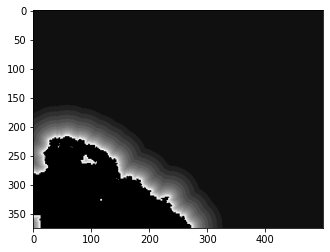

In [59]:
imshow(img, 'gray')

In [60]:
img = np.array(img).astype(dtype=int)
np.unique(img)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [61]:
img[img>=1] -= 1
np.unique(img)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [62]:
img = torch.from_numpy(img).type(torch.LongTensor)

In [64]:
img.unique()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [25]:
img_r = img.resize((512,512))

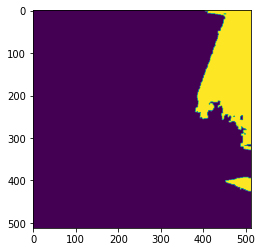

In [28]:
imshow(img_r)

In [3]:
from scipy import ndimage

In [9]:
path = '/nfs/bigcornea/add_disk0/shilinhu/SBU/SBUTrain4KRecoveredSmall/ShadowMasks/lssd39.png'

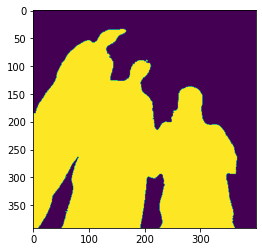

In [10]:
img = Image.open(path).convert('L')
imshow(img)

In [11]:
path = '/nfs/bigcornea/add_disk0/shilinhu/SBU/SBUTrain4KRecoveredSmall/LevelSets/lssd39.png'

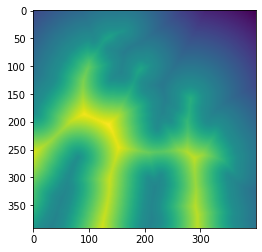

In [15]:
img = Image.open(path).convert('L')
imshow(img)

In [62]:
img = Image.open(path).convert('L')
img = np.array(img).astype(dtype=float)
ss_map = img.copy()
ss_map[ss_map >= 1] = 1
dis_map_inside = ndimage.distance_transform_edt(ss_map)
dis_map_outside = ndimage.distance_transform_edt(1-ss_map)
dis_map_inside[dis_map_inside>0] -= 1
dis_map_inside = dis_map_inside / (2*dis_map_inside.max())
dis_map_outside = dis_map_outside / (2*dis_map_outside.max())
level_set = dis_map_inside - dis_map_outside + 0.5

In [63]:
level_set

array([[7.32633904e-02, 7.37109664e-02, 7.41563043e-02, ...,
        1.70740604e-04, 8.65166666e-05, 0.00000000e+00],
       [7.42389257e-02, 7.46875284e-02, 7.51338898e-02, ...,
        1.24150627e-03, 1.15710155e-03, 1.07039924e-03],
       [7.52139860e-02, 7.56636195e-02, 7.61110087e-02, ...,
        2.31225804e-03, 2.22767176e-03, 2.14078301e-03],
       ...,
       [9.63161627e-01, 9.61742975e-01, 9.54946326e-01, ...,
        4.54892396e-01, 4.54892396e-01, 4.54892396e-01],
       [9.81578950e-01, 9.78842685e-01, 9.72282914e-01, ...,
        4.53818405e-01, 4.53818405e-01, 4.53818405e-01],
       [1.00000000e+00, 9.96037116e-01, 9.89699351e-01, ...,
        4.52744415e-01, 4.52744415e-01, 4.52744415e-01]])

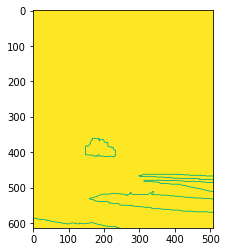

In [66]:
level_set[level_set!=0.5]=1
imshow(level_set)

In [2]:
path = '/home/shilinhu/unet/results/levelset/test_latest_iter20000'

In [4]:
for img in os.listdir(path):
    if img.endswith('.png') and 'output1' in img:
        print(img)
        image = Image.open(os.path.join(path, img))
        image = np.array(image)
        image[image>127] = 255
        image[image<128] = 0
        Image.fromarray(image).save(os.path.join(path, img[:-12]+'.png'))

WQxOk9kU6qA_output1.png
32209_2_5237fa43e087c3684ef2a079_output1.png
david-ferrer-tennis_output1.png
h36_1_output1.png
856_poliblok-15_output1.png
945031206_output1.png
wJyFq_output1.png
h61_3_output1.png
north40place_output1.png
COCO_train2014_000000216694_output1.png
COCO_train2014_000000054254_output1.png
s_synagogue_outdoor_synagogue_000122_output1.png
image74735271_output1.png
IS-1cjdmw8dkq3q5_output1.png
2239252te_output1.png
7752524382_c5b7b977ba_b_output1.png
maxresdefault1_output1.png
rusbrick2_output1.png
h19_1_output1.png
cb16716189_d_output1.png
017_output1.png
upcycled-pallet-coffee-table-and-TV-stand_output1.png
snow002_output1.png
dscf2512_output1.png
13191932324_cb403f5c0e_output1.png
h39_2_output1.png
mezaryapim (3)_output1.png
Grigor+Dimitrov+Legg+Mason+Tennis+Classic+f6LbS_YHtOml_output1.png
87563_output1.png
11516579-bolt-w-washer-ring-screw-llc-holly-mi_output1.png
corn-shadow-2_output1.png
DSCF1850-1_output1.png
f9ec164093c4ec1623906b7096aeead7_output1.png
2715553

old-street-lamp-and-shadows-against-brick-wall_output1.png
orig_89264214_UNvi_output1.png
Optimized-IMGP0273-2_output1.png
brickwallte_output1.png
9538_output1.png
Sanctuary_view_dayte_output1.png
h42_2_output1.png
COCO_train2014_000000009988_output1.png
161303092_output1.png
snovwafwq_output1.png
s-decorative-sammy-kershaw-red-wood-deck-redwood-deck-designs-redwood-deck-restore-redwood-deck-design-redwood-deck-cleaning-procedures-redwood-deck-cleaner-redwood-deck-construction-details-retes_output1.png
Shadow-on-beach_output1.png
h13_1_output1.png
tendark_output1.png
finding-a-glove-1427409_output1.png
ssulaiman_umbrella1_output1.png
h54_2_output1.png
COCO_train2014_000000012459_output1.png
zboard_output1.png
h2_2_output1.png
1319615601_img_9770_output1.png
Artificial-Grass-for-Dogs-5_output1.png
ana-ivanovic-2015-french-tennis-open-at-roland-garros-in-paris-2nd-round_3_output1.png
h35_1_output1.png
lhiformag_output1.png
11.wall_output1.png
8ccb88s-960_output1.png
shadow_sm_output1.png

3b37dc70ffee3cf2aa59d8473a1e87e5_735x418_output1.png
h65_1_output1.png
somerset-garden-yurt-and-gypsy-caravan-large_output1.png
h86_1_output1.png
photocase4422822755116391_output1.png
brisk-winter-day_output1.png
6150517_output1.png
DerekMillercupofcopy-e1364567004145_output1.png
COCO_train2014_000000144561_output1.png
4-Shadow-300x226_output1.png
screw-rusty-wood-old-weathered_output1.png
COCO_train2014_000000010719_output1.png
5.1.21_boardwalk_settings_9637_09242012_0_output1.png
12_3_-_Only_the_shadow_knows_output1.png
5e3c28cs-960_output1.png
9473f9u-960_output1.png
Sacsayhuaman_output1.png
5938814s-960_output1.png
1216851254719_f_output1.png
rusPoste1_output1.png
h44_1_output1.png
h45_1_output1.png
fileshare1_output1.png
COCO_train2014_000000212331_output1.png
COCO_train2014_000000493880_output1.png
P2180419te_output1.png
697391te_output1.png
tfile_image-4_output1.png
COCO_train2014_000000037327_output1.png
shadowsafa_output1.png
1310391610_output1.png
full_walkingsign-and-shadow_

In [5]:
path = '/home/shilinhu/unet/results/levelset/test_latest_iter20000/david-ferrer-tennis.png'

In [6]:
img = Image.open(path).convert('L')

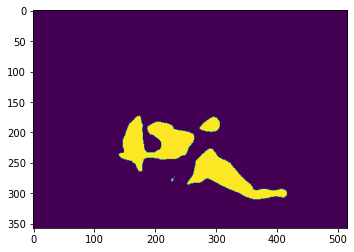

In [7]:
imshow(img)

In [8]:
path = '/nfs/bigcornea/add_disk0/shilinhu/SBU/SBU-Test/ShadowMasks/david-ferrer-tennis.png'

In [9]:
img = Image.open(path).convert('L')

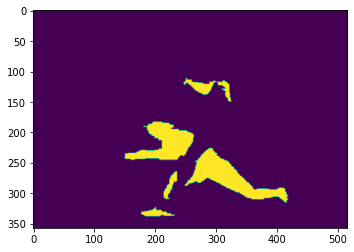

In [10]:
imshow(img)

# optical flow generation

In [10]:
video_list = []
img_list = '/data/add_disk0/shilinhu/small_shadow/train'
for tmp in os.listdir(img_list):
    if os.path.isdir(os.path.join(img_list, tmp)):
        video_list.append(os.path.join(img_list, tmp))
for video in video_list:
    im_list = []
    for img_name in os.listdir(video):
        if img_name.endswith('.jpg'):
            im_list.append(os.path.join(video, img_name))
    im_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f.split('/')[-1]))))
    list_len = len(im_list)
    for i in range(list_len-1):
        imgs = [img for img in im_list[i:i+2]]
        imgs.reverse()
        print(imgs)

['/data/add_disk0/shilinhu/small_shadow/train/sv254/frame1.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv254/frame0.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv254/frame2.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv254/frame1.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv254/frame3.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv254/frame2.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv254/frame4.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv254/frame3.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv254/frame5.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv254/frame4.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv254/frame6.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv254/frame5.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv254/frame7.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv254/frame6.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv254/frame8.jpg', '/data/add_disk0/shilinhu/small_

['/data/add_disk0/shilinhu/small_shadow/train/sv021/frame528.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv021/frame527.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv021/frame529.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv021/frame528.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv021/frame530.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv021/frame529.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv106/frame1.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv106/frame0.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv106/frame2.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv106/frame1.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv106/frame3.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv106/frame2.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv106/frame4.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv106/frame3.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv106/frame5.jpg', '/data/add_disk0/shi

['/data/add_disk0/shilinhu/small_shadow/train/sv019/frame1.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv019/frame0.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv019/frame2.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv019/frame1.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv019/frame3.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv019/frame2.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv019/frame4.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv019/frame3.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv019/frame5.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv019/frame4.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv019/frame6.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv019/frame5.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv019/frame7.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv019/frame6.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv019/frame8.jpg', '/data/add_disk0/shilinhu/small_

['/data/add_disk0/shilinhu/small_shadow/train/sv033/frame432.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv033/frame431.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv033/frame433.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv033/frame432.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv033/frame434.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv033/frame433.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv033/frame435.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv033/frame434.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv033/frame436.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv033/frame435.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv033/frame437.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv033/frame436.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv033/frame438.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv033/frame437.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv033/frame439.jpg', '/

['/data/add_disk0/shilinhu/small_shadow/train/sv011/frame1.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv011/frame0.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv011/frame2.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv011/frame1.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv011/frame3.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv011/frame2.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv011/frame4.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv011/frame3.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv011/frame5.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv011/frame4.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv011/frame6.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv011/frame5.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv011/frame7.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv011/frame6.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv011/frame8.jpg', '/data/add_disk0/shilinhu/small_

['/data/add_disk0/shilinhu/small_shadow/train/sv272/frame1.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv272/frame0.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv272/frame2.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv272/frame1.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv272/frame3.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv272/frame2.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv272/frame4.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv272/frame3.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv272/frame5.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv272/frame4.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv272/frame6.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv272/frame5.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv272/frame7.jpg', '/data/add_disk0/shilinhu/small_shadow/train/sv272/frame6.jpg']
['/data/add_disk0/shilinhu/small_shadow/train/sv272/frame8.jpg', '/data/add_disk0/shilinhu/small_

# optical flow usage

In [2]:
flow_path = '/nfs/bigcornea/add_disk0/shilinhu/flow/sv254/flow_frame2.npy'
image_path_1 = '/nfs/bigcornea/add_disk0/shilinhu/small_shadow/train/sv254/frame2.jpg'
image_path_2 = '/nfs/bigcornea/add_disk0/shilinhu/small_shadow/train/sv254/frame3.jpg'

In [7]:
a = transforms.ToTensor()(Image.open(image_path_1)).view(1,3,720,1280)
b = transforms.ToTensor()(Image.open(image_path_2)).view(1,3,720,1280)

In [8]:
B, C, H, W = b.size()

xx = torch.arange(0, W).view(1,-1).repeat(H,1)

yy = torch.arange(0, H).view(-1,1).repeat(1,W)

xx = xx.view(1,1,H,W).repeat(B,1,1,1)

yy = yy.view(1,1,H,W).repeat(B,1,1,1)

grid = torch.cat((xx,yy),1).float()

In [9]:
grid.size()

torch.Size([1, 2, 720, 1280])

In [14]:
flow = np.load(flow_path).transpose(2,0,1)
flow = torch.from_numpy(flow).view(1,2,720,1280)

In [17]:
vgrid = grid + flow

vgrid[:,0,:,:] = 2.0*vgrid[:,0,:,:].clone() / max(W-1,1)-1.0

vgrid[:,1,:,:] = 2.0*vgrid[:,1,:,:].clone() / max(H-1,1)-1.0

In [20]:
warped_image = torch.nn.functional.grid_sample(b, vgrid.permute(0,2,3,1), 'nearest', 'border', False)

In [24]:
warped_img = transforms.functional.to_pil_image(warped_image.squeeze(0), mode=None)

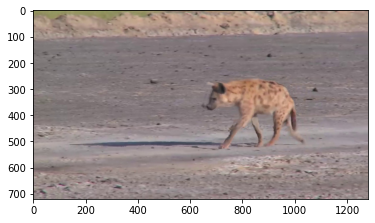

In [25]:
imshow(warped_img)

In [121]:
img1 = cv2.imread(image_path_1)
img2 = cv2.imread(image_path_2)

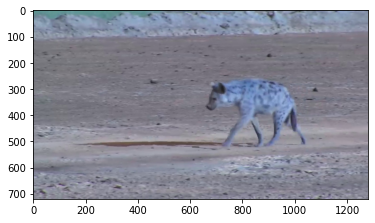

In [122]:
imshow(img1)

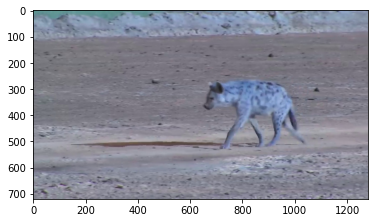

In [123]:
imshow(img2)

In [124]:
flow = np.load(flow_path)

In [125]:
flow.shape

(720, 1280, 2)

In [126]:
h = flow.shape[0]
w = flow.shape[1]
flow[:,:,0] += np.arange(w)
flow[:,:,1] += np.arange(h)[:,np.newaxis]

In [127]:
new_img = cv2.remap(img2, flow, None, cv2.INTER_LINEAR)

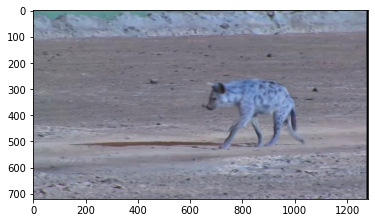

In [128]:
imshow(new_img)

In [18]:
path = '/nfs/bigcornea/add_disk0/shilinhu/ViSha/train/flow12/baby_cat/00000002.npy'

In [19]:
flow = np.load(path)

In [20]:
flow

array([[[ 2.21033320e-02, -4.77778085e-04],
        [ 2.19219718e-02,  1.49089680e-03],
        [ 2.17072368e-02,  3.44020943e-03],
        ...,
        [-1.49824888e-01, -1.08090259e-01],
        [-1.59378275e-01, -1.07937306e-01],
        [-1.68926731e-01, -1.07822955e-01]],

       [[ 2.13136990e-02, -4.21049632e-03],
        [ 2.09551267e-02, -5.32935513e-03],
        [ 2.05626208e-02, -6.46446459e-03],
        ...,
        [-1.52816087e-01, -1.29835397e-01],
        [-1.60939634e-01, -1.26583129e-01],
        [-1.69058517e-01, -1.23356327e-01]],

       [[ 2.05240641e-02, -7.94321485e-03],
        [ 1.99882798e-02, -1.21496078e-02],
        [ 1.94180030e-02, -1.63691398e-02],
        ...,
        [-1.55807257e-01, -1.51580527e-01],
        [-1.62501022e-01, -1.45228937e-01],
        [-1.69190302e-01, -1.38889715e-01]],

       ...,

       [[-6.57396436e-01, -8.99257660e-01],
        [-6.77545965e-01, -9.00255561e-01],
        [-6.97695255e-01, -9.01229620e-01],
        ...,
     

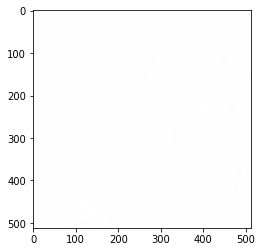

In [25]:
imshow(transflow)

In [26]:
transflow = np.asarray(transflow)

In [27]:
transflow.shape

(512, 512, 3)

In [28]:
np.max(transflow)

255

In [29]:
np.min(transflow)

252